# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image as image_preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [2]:
# Generate data paths with labels
def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='filepaths')
    lseries = pd.Series(labels, name='labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)


data_dir = './Multi-class Weather Dataset'
df = create_dataframe(data_dir)
# df = df.sample(frac=0.5, random_state=123)  # half cut the whole dataset

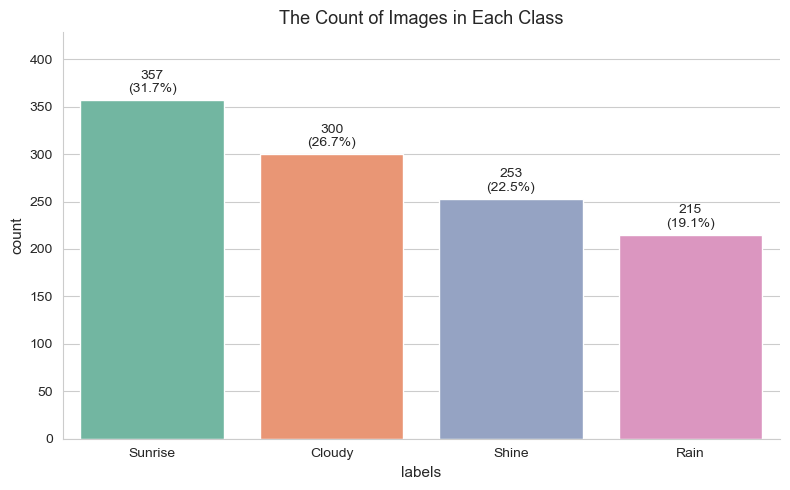

In [3]:
def plot_class_balance(df, title):
    class_counts = df['labels'].value_counts()
    class_percent = class_counts / len(df) * 100

    # seaborn style
    sns.set_style("whitegrid")
    palette = sns.color_palette("Set2")

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = sns.barplot(
        x=class_counts.index,
        y=class_counts.values,
        palette=palette,
        ax=ax
    )

    # title: amount and percentage
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        pct = class_percent[i]
        label = f'{int(height)}\n({pct:.1f}%)'
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5, label,
                ha='center', va='bottom', fontsize=10)

    ax.set_title(f'The Count of Images in Each Class', fontsize=13)
    ax.set_xlabel('labels', fontsize=11)
    ax.set_ylabel('count', fontsize=11)
    ax.set_ylim(0, max(class_counts.values) * 1.2)
    sns.despine(top=True, right=True)

    plt.tight_layout()
    plt.show()


# visualize the count of images in each class
plot_class_balance(df, "Data Set")

### **Split dataframe into train, valid, and test**

In [4]:
# train dataframe
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

### **Create image data generator**

In [5]:
def get_image_data_generator(train=True):
    if train:
        return ImageDataGenerator(
            rescale=1. / 255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    else:
        return ImageDataGenerator(
            rescale=1./255,
        )

In [6]:
# crobed image size
batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# ImageDataGenerator for training data with data augmentation
train_datagen = get_image_data_generator(train=True)

# ImageDataGenerator for validation/test data without augmentation, only rescaling
test_datagen = get_image_data_generator(train=False)

# Training Generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation Generator
valid_gen = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Testing Generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print(img_shape)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
(150, 150, 3)


### **Show sample from train data**

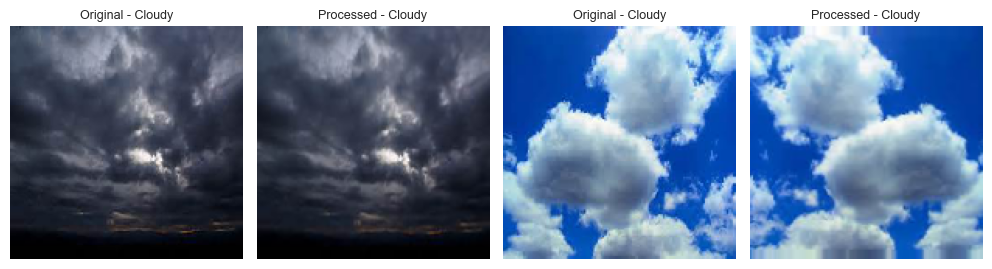

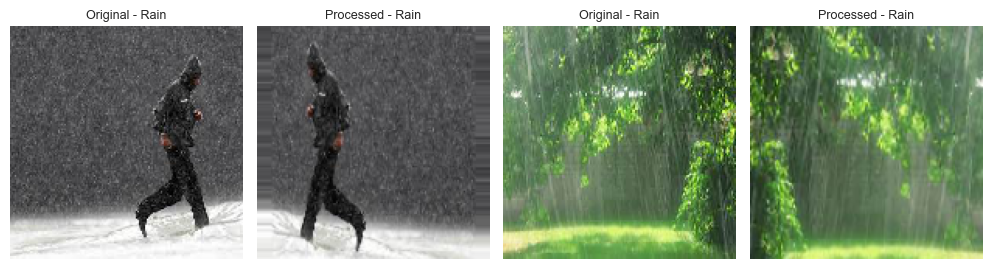

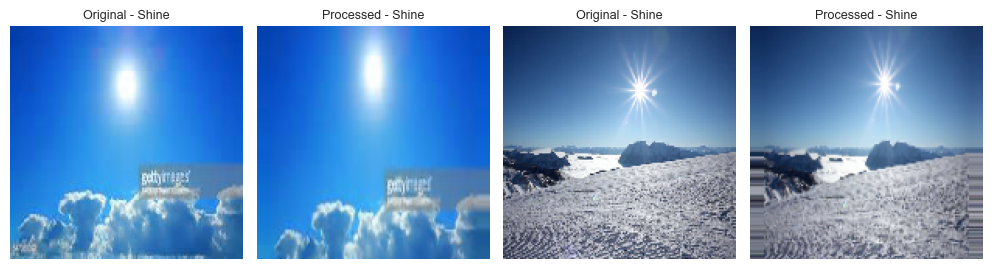

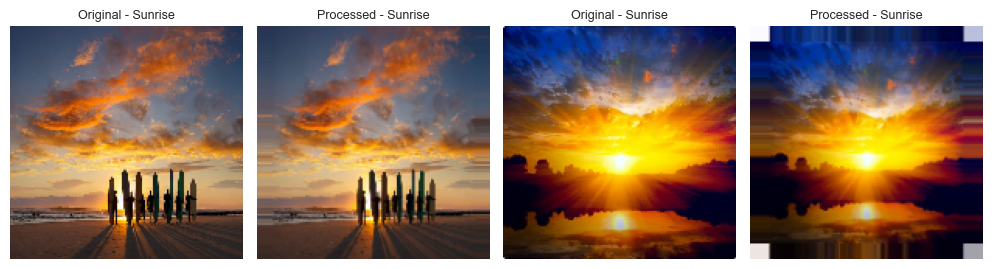

In [7]:
import matplotlib.pyplot as plt
import random

classes = df['labels'].unique()
gen = get_image_data_generator(train=True)

for cls in classes:
    # randomly sample 2 images from the class
    sample_rows = df[df['labels'] == cls].sample(n=2, random_state=42).reset_index(drop=True)

    fig, axes = plt.subplots(1, 4, figsize=(10, 3))  # 1 row, 4 images: 2 originals + 2 augmentations

    for i in range(2):
        img_path = sample_rows.loc[i, 'filepaths']
        img = image_preprocessing.load_img(img_path, target_size=img_size)
        x = image_preprocessing.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Original image
        axes[2 * i].imshow(img)
        axes[2 * i].set_title(f"Original - {cls}", fontsize=9)
        axes[2 * i].axis('off')

        # Augmented image
        aug_iter = gen.flow(x, batch_size=1, shuffle=False)
        aug_img = next(aug_iter)[0]
        axes[2 * i + 1].imshow(aug_img)
        axes[2 * i + 1].set_title(f"Processed - {cls}", fontsize=9)
        axes[2 * i + 1].axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

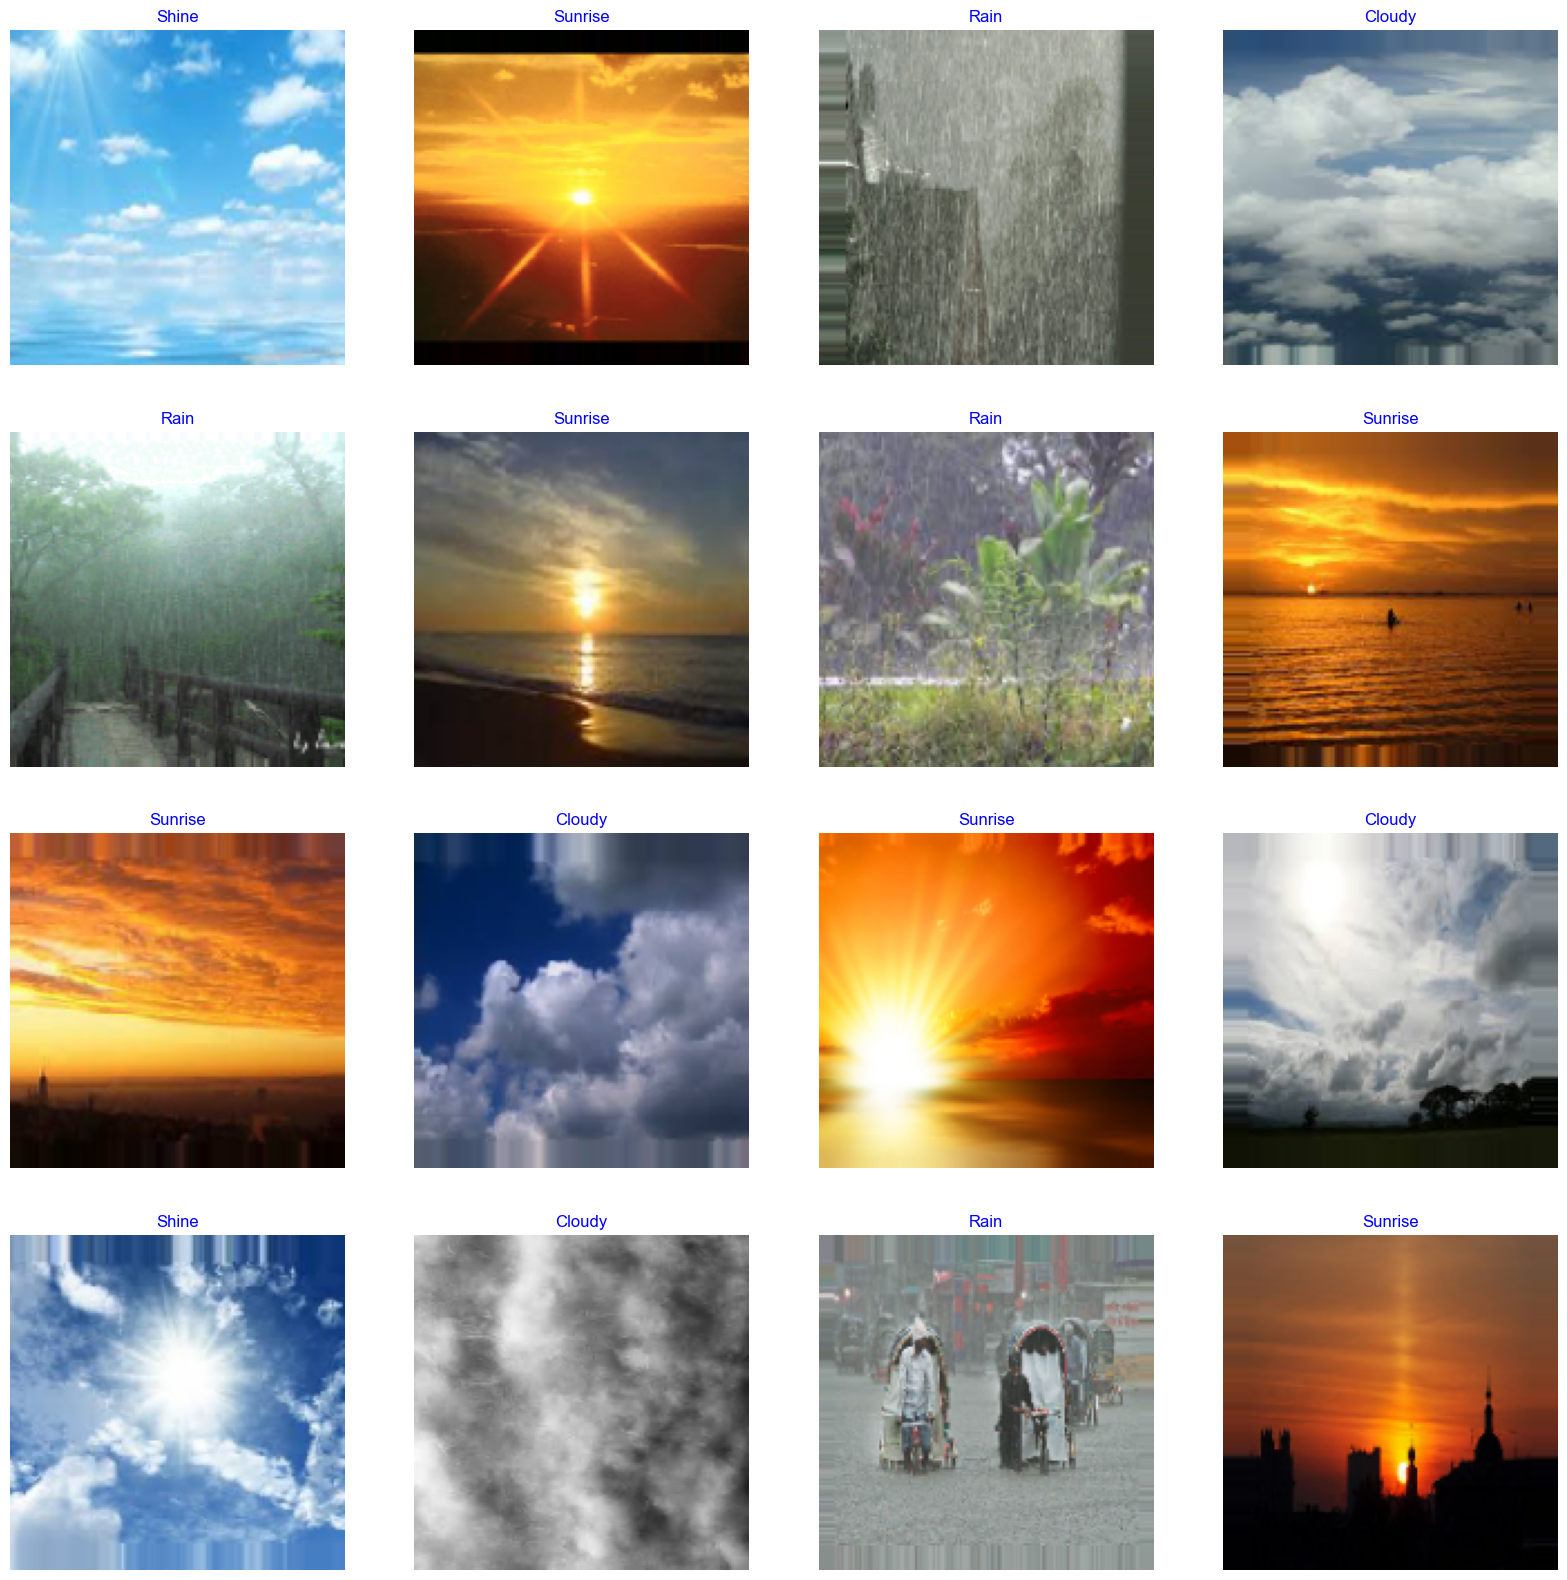

In [8]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's kays (classes), classes names : string
images, labels = next(iter(train_gen))  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [9]:
# Create Model Structure - Xception model
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape,
    pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,395,244
Trainable params: 21,336,620
Non-trainable params: 58,624
_______________________________________

#### **Train model**

In [10]:
epochs = 10  # number of all epochs in training

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)

Epoch 1/10


2025-07-30 15:44:02.364797: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


29/29 [==============================] - 71s 2s/step - loss: 0.5485 - accuracy: 0.8222 - precision: 0.8410 - recall: 0.8111 - auc: 0.9632 - val_loss: 1.8724 - val_accuracy: 0.6889 - val_precision: 0.6889 - val_recall: 0.6889 - val_auc: 0.8630
Epoch 2/10
29/29 [==============================] - 66s 2s/step - loss: 0.1619 - accuracy: 0.9578 - precision: 0.9609 - recall: 0.9556 - auc: 0.9924 - val_loss: 2.2657 - val_accuracy: 0.7259 - val_precision: 0.7239 - val_recall: 0.7185 - val_auc: 0.8735
Epoch 3/10
29/29 [==============================] - 64s 2s/step - loss: 0.1076 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - val_loss: 0.8630 - val_accuracy: 0.8519 - val_precision: 0.8519 - val_recall: 0.8519 - val_auc: 0.9452
Epoch 4/10
29/29 [==============================] - 63s 2s/step - loss: 0.0544 - accuracy: 0.9822 - precision: 0.9855 - recall: 0.9789 - auc: 0.9989 - val_loss: 0.5359 - val_accuracy: 0.9111 - val_precision: 0.9179 - val_recall: 0.9111 - val_auc: 0.

#### **Display model performance**

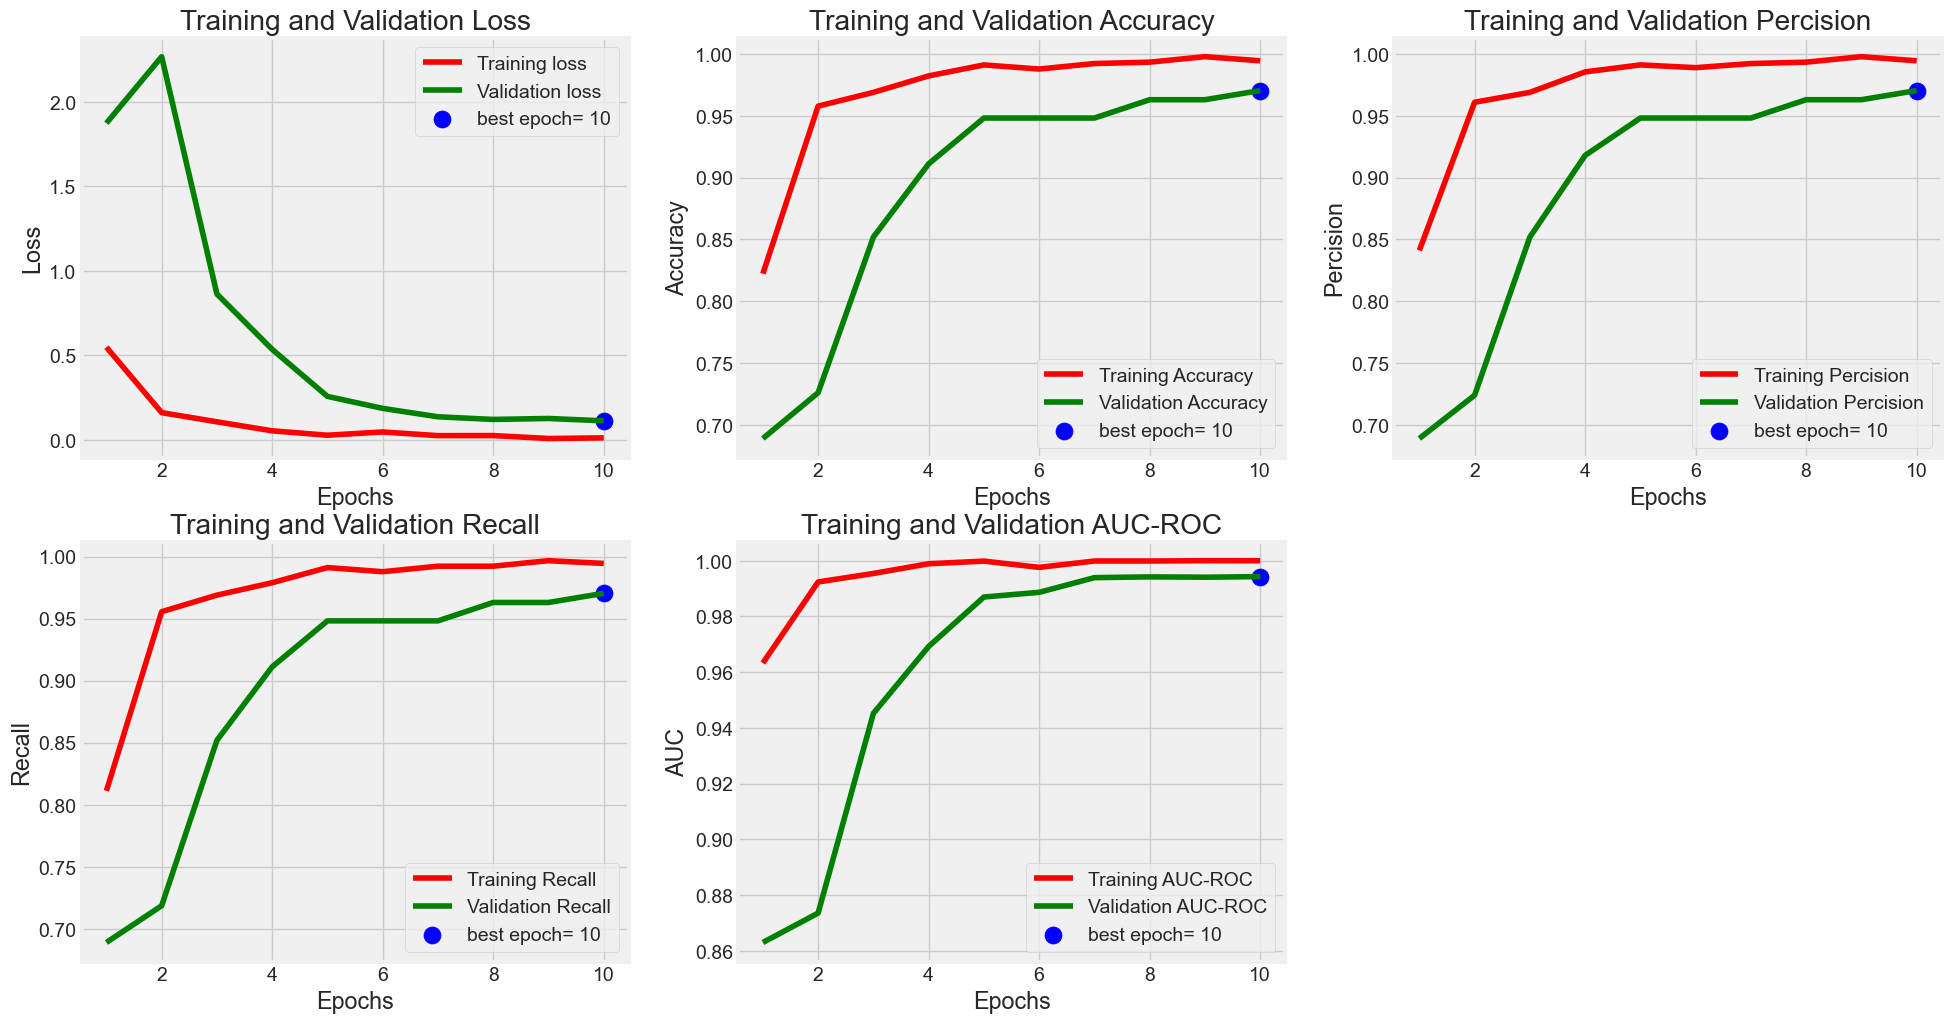

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_perc = history.history['precision']
tr_recall = history.history['recall']
tr_auc = history.history['auc']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

# Plot training history
plt.figure(figsize=(24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label='Training Percision')
plt.plot(Epochs, val_perc, 'g', label='Validation Percision')
plt.scatter(index_perc + 1, perc_highest, s=150, c='blue', label=perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label='Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label='Validation AUC-ROC')
plt.scatter(index_auc + 1, auc_highest, s=150, c='blue', label=auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

<Figure size 640x480 with 0 Axes>

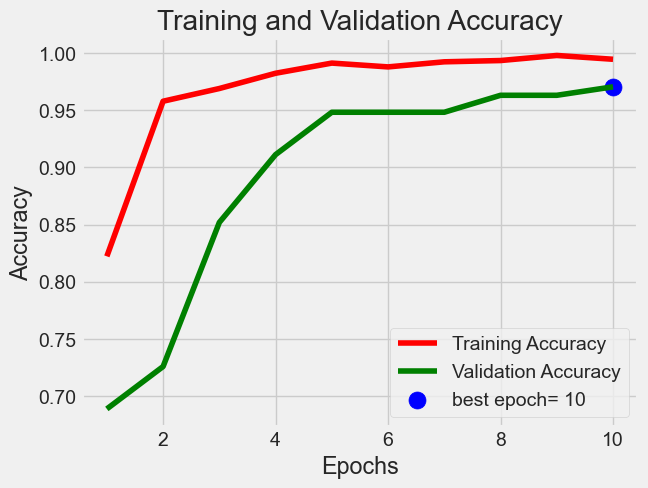

In [12]:
plt.tight_layout()
plt.show()
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# **Evaluate model**

In [13]:
ts_length = len(test_df)
test_batch_size = max(
    sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 1s 547ms/step - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Train Loss:  4.345704292063601e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.18745727837085724
Validation Accuracy:  0.953125
--------------------
Test Loss:  0.017540844157338142
Test Accuracy:  1.0


# **Get Predictions**

In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

3/3 [==============================] - 2s 493ms/step


#### **Confusion Matrics and Classification Report**

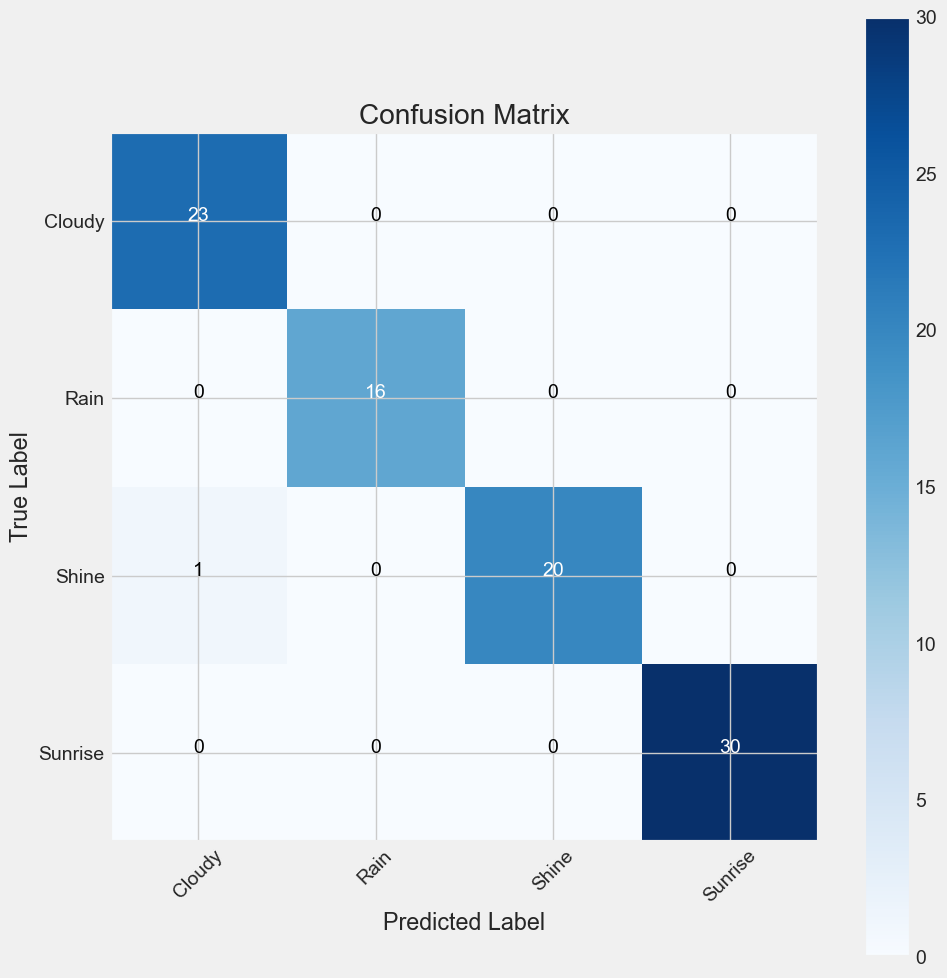

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Cloudy       0.96      1.00      0.98        23
        Rain       1.00      1.00      1.00        16
       Shine       1.00      0.95      0.98        21
     Sunrise       1.00      1.00      1.00        30

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



### **Visualize Misclassified Test Images and Preprocessing Effects**


Misclassified Samples: 1


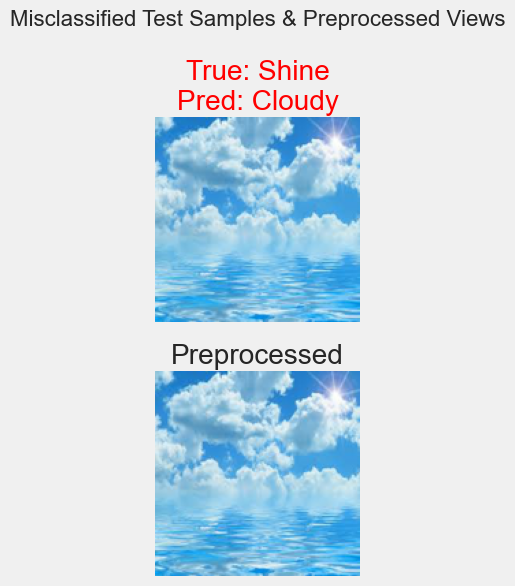

In [17]:
# Get the true labels and file paths for misclassified samples
y_true = test_gen.classes
filepaths = test_df["filepaths"].values

# mapping class indices to class names
inv_class_indices = {v: k for k, v in test_gen.class_indices.items()}

# identify misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Misclassified Samples: {len(misclassified_indices)}")

# sample a few misclassified images
sampled = random.sample(list(misclassified_indices), min(8, len(misclassified_indices)))

plt.figure(figsize=(18, 6))

for i, idx in enumerate(sampled):
    # obtain the true label and predicted label
    img_path = filepaths[idx]
    raw_img = Image.open(img_path).resize(img_size)

    # display original image
    plt.subplot(2, len(sampled), i + 1)
    plt.imshow(raw_img)
    plt.title(f"True: {inv_class_indices[y_true[idx]]}\nPred: {inv_class_indices[y_pred[idx]]}", color="red")
    plt.axis("off")

    # display preprocessed image
    plt.subplot(2, len(sampled), len(sampled) + i + 1)
    preprocessed_img = np.array(raw_img) / 255.0
    plt.imshow(preprocessed_img)
    plt.title("Preprocessed")
    plt.axis("off")

plt.suptitle("Misclassified Test Samples & Preprocessed Views", fontsize=16)
plt.tight_layout()
plt.show()

#### **Save model**

In [18]:
#Save the model
model.save('ًWeather Model.h5')